# 数据挖掘互评作业三：分类、预测与聚类

## 选择问题2.1 Hotel booking demand, 酒店预订需求

该数据集包含城市酒店和度假酒店的预订信息，包括预订时间、停留时间，成人/儿童/婴儿人数以及可用停车位数量等信息。

数据量：32列共12W数据。



### 导入数据集

In [1]:
!pip install pycountry

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pycountry as pc

pd.options.display.max_columns = None

  Created wheel for pycountry: filename=pycountry-20.7.3-py2.py3-none-any.whl size=10746863 sha256=eb92df9542db6e60dce58729c30457c56e6dd1f0b31577b3b529cbc6bfc55aa4
  Stored in directory: c:\users\sure\appdata\local\pip\cache\wheels\57\e8\3f\120ccc1ff7541c108bc5d656e2a14c39da0d824653b62284c6
Successfully built pycountry


In [2]:
#导入数据集
data = pd.read_csv('hotel_bookings.csv')

In [3]:
#显示前五行数据
data.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


### 数据预处理

In [4]:
df = data.copy()

#### 1.处理缺失数据

In [5]:
#查找缺少的值，显示每一列的总空值并按降序对其进行排序
df.isnull().sum().sort_values(ascending=False)[:10]

company                   112593
agent                      16340
country                      488
children                       4
reserved_room_type             0
assigned_room_type             0
booking_changes                0
deposit_type                   0
hotel                          0
previous_cancellations         0
dtype: int64

可以看出公司、代理和国家是缺失最多的数据

In [6]:
#删除没有成人、婴儿和儿童的行
df = df.drop(df[(df.adults+df.babies+df.children)==0].index)

#如果公司或代理的ID不为空，就将其替换为0
df[['agent','company']] = df[['agent','company']].fillna(0.0)

#对于“国家/地区”列中缺少的值，将其替换为最常出现的值
df['country'].fillna(data.country.mode().to_string(), inplace=True)

#对于缺失的儿童值，将其替换为四舍五入的平均值
df['children'].fillna(round(data.children.mean()), inplace=True)

#### 2.转换数据类型

In [7]:
#这将些列的数据类型从float转换为integer
df[['children', 'company', 'agent']] = df[['children', 'company', 'agent']].astype('int64')

### 探索性数据分析

In [11]:
def plot(x, y, x_label=None,y_label=None, title=None, figsize=(7,5), type='bar'):
    
    '''
显示
    '''
    
    sns.set_style('darkgrid')
    
    fig, ax = plt.subplots(figsize=figsize)
    
    if x_label != None:
        ax.set_xlabel(x_label)
    
    if y_label != None:
        ax.set_ylabel(y_label)
        
    if title != None:
        ax.set_title(title)
    
    if type == 'bar':
        sns.barplot(x,y, ax = ax)
    elif type == 'line':
        sns.lineplot(x,y, ax = ax)
        
    
    plt.show()

In [12]:
def get_count(series, limit=None):
    
    '''
    计数
    '''
    
    if limit != None:
        series = series.value_counts()[:limit]
    else:
        series = series.value_counts()
    
    x = series.index
    y = series/series.sum()*100
    
    return x.values,y.values

### 1、基本情况：城市酒店和假日酒店预订需求和入住率比较；

C:\Users\sure\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


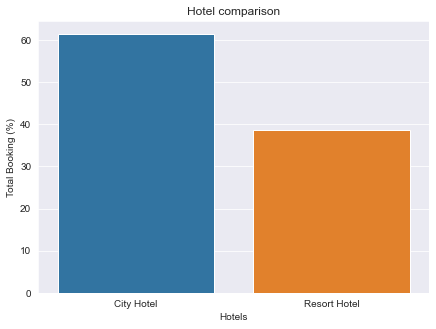

In [13]:
df_not_canceled = df[df['is_canceled'] == 0]
x,y = get_count(df_not_canceled['hotel'])
plot(x,y, x_label='Hotels', y_label='Total Booking (%)', title='Hotel comparison')

#### 可以看出城市酒店的预订需求和入住率比假日酒店的高。

### 2、用户行为：提前预订时间、入住时长、预订间隔、餐食预订情况；

C:\Users\sure\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


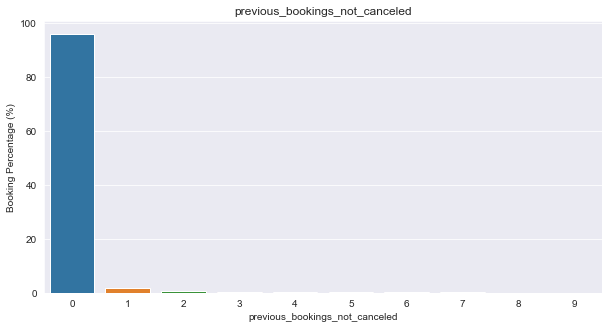

In [19]:
#提前预订时间
previous_bookings_not_canceled = df_not_canceled['previous_bookings_not_canceled']
x,y = get_count(previous_bookings_not_canceled, limit=10)

plot(x,y, x_label='previous_bookings_not_canceled', y_label='Booking Percentage (%)', title='previous_bookings_not_canceled', figsize=(10,5))


C:\Users\sure\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


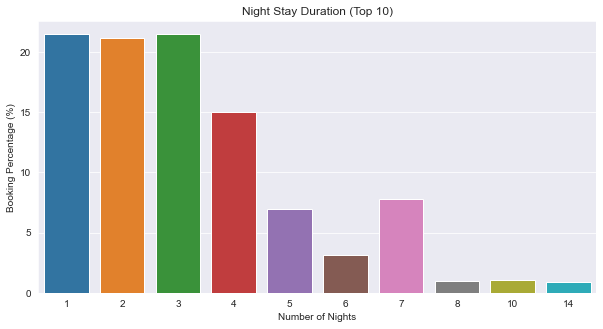

In [15]:
#入住时长
total_nights = df_not_canceled['stays_in_weekend_nights']+ df_not_canceled['stays_in_week_nights']
x,y = get_count(total_nights, limit=10)

plot(x,y, x_label='Number of Nights', y_label='Booking Percentage (%)', title='Night Stay Duration (Top 10)', figsize=(10,5))


可以看出入住1-3天的人最多，其次是入住4天、7天、5天。

C:\Users\sure\Anaconda3\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


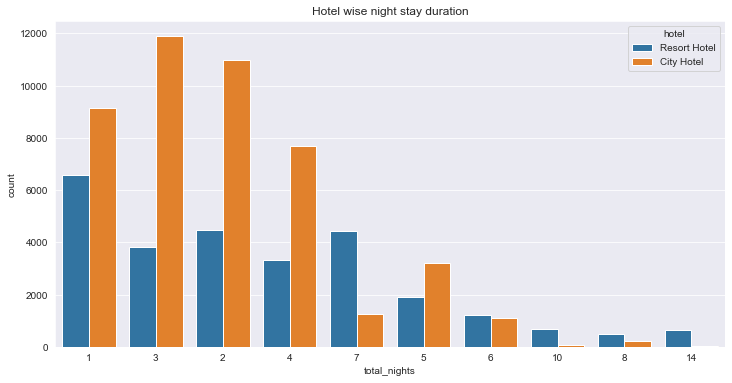

In [24]:
#对比查看入住时长
df_not_canceled.loc[:,'total_nights'] = df_not_canceled['stays_in_weekend_nights']+ df_not_canceled['stays_in_week_nights']

fig, ax = plt.subplots(figsize=(12,6))
ax.set_xlabel('No of Nights')
ax.set_ylabel('No of Nights')
ax.set_title('Hotel wise night stay duration')
sns.countplot(x='total_nights', hue='hotel', data=df_not_canceled,
              order = df_not_canceled.total_nights.value_counts().iloc[:10].index, ax=ax);

C:\Users\sure\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


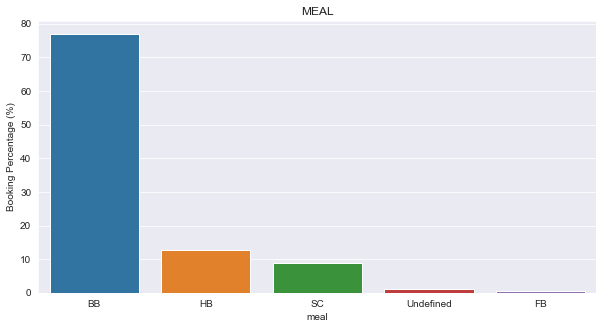

In [23]:
#餐食预订情况
total_meal = df_not_canceled['meal']
x,y = get_count(total_meal, limit=10)

plot(x,y, x_label='meal', y_label='Booking Percentage (%)', title='MEAL', figsize=(10,5))


可以看出，预订BB的人最多，HB次之，然后是SC，Undefined和FB。

### 3、一年中最佳预订酒店时间；

C:\Users\sure\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


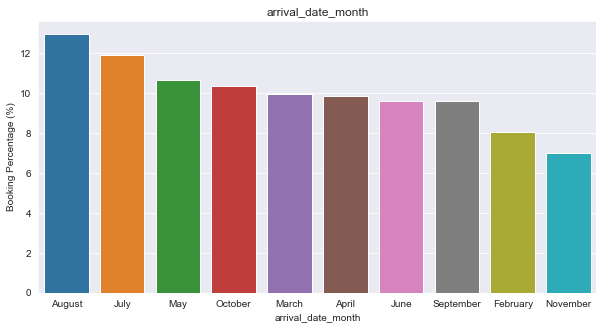

In [26]:
#arrival_date_month
arrival_date_month = df_not_canceled['arrival_date_month']
x,y = get_count(arrival_date_month, limit=10)

plot(x,y, x_label='arrival_date_month', y_label='Booking Percentage (%)', title='arrival_date_month', figsize=(10,5))


可以看出一年中八月和七月是最繁忙的月份，一月和十二月是空置最多的月份。

### 4、利用Logistic预测酒店预订

In [33]:
hotel_data = data.copy()
drop_columns=['agent','company','hotel','reservation_status_date']
hotel_data.drop(inplace=True, axis=1, labels=drop_columns)
print("The shape of data after drop nan:",hotel_data.shape)
hotel_data.isnull().sum()
hotel_data.fillna(hotel_data.mode().iloc[0], inplace=True)
hotel_data.isnull().sum()

The shape of data after drop nan: (119390, 28)


is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
assigned_room_type                0
booking_changes                   0
deposit_type                      0
days_in_waiting_list              0
customer_type                     0
adr                               0
required_car_parking_spaces       0
total_of_special_requests         0
reservation_status          

In [34]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

In [35]:
# X 为特征，y为标签
X = hotel_data.iloc[:,1:]
y = hotel_data.iloc[:,0]

In [36]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 27 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   lead_time                       119390 non-null  int64  
 1   arrival_date_year               119390 non-null  int64  
 2   arrival_date_month              119390 non-null  object 
 3   arrival_date_week_number        119390 non-null  int64  
 4   arrival_date_day_of_month       119390 non-null  int64  
 5   stays_in_weekend_nights         119390 non-null  int64  
 6   stays_in_week_nights            119390 non-null  int64  
 7   adults                          119390 non-null  int64  
 8   children                        119390 non-null  float64
 9   babies                          119390 non-null  int64  
 10  meal                            119390 non-null  object 
 11  country                         119390 non-null  object 
 12  market_segment  

因为数据同时具有数值特征和非数值特征，而Logistics Regression只能处理数值特征，所以使用sklearn.OneHotEncoder将非数值特征转化为数值特征。

In [37]:
need_transfer=['meal','distribution_channel','reservation_status','country','arrival_date_month','market_segment',
 'deposit_type','customer_type', 'reserved_room_type','assigned_room_type' ]
transfer = make_column_transformer(
    (OneHotEncoder(),need_transfer), remainder = 'passthrough'
    )
X = transfer.fit_transform(X).toarray()

将数据集的80%作为训练集，剩余的20%作为测试集。

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [39]:
X_train.shape

(95512, 256)

非数值特征处理

In [40]:
stander = StandardScaler()
X_train = stander.fit_transform(X_train)
X_test = stander.transform(X_test)

pca = PCA(n_components = 100)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
explained_variance = pca.explained_variance_ratio_

print("降维后的训练数据:",X_train.shape,"\n测试数据:",X_test.shape)
print("降维后的训练数据:",X_train,"\n测试数据:",X_test)

降维后的训练数据: (95512, 100) 
测试数据: (23878, 100)
降维后的训练数据: [[-2.58608045  2.76478448  1.68098888 ...  4.80272185 -1.72163355
   6.57674857]
 [-2.08112568  2.26330555  1.23601626 ... -0.47851781 -1.50937066
  -1.08887666]
 [-1.40744083  0.10963425 -1.38138457 ... -0.01673589 -0.7241488
   0.40022078]
 ...
 [-2.67108999  0.16216401  0.05107102 ...  0.75395672 -1.40218139
  -0.90421753]
 [ 1.46549337 -0.6488795  -2.51754059 ... -0.18364691  0.26975794
  -0.54456701]
 [ 3.87718256  1.20290197  2.81267082 ... -0.15380042  0.293859
   0.20261217]] 
测试数据: [[ 0.84562692  0.66888513 -1.39419401 ... -0.38151853 -0.16472217
   0.41804819]
 [-0.33360379  0.87889228 -1.33835735 ...  0.34645337 -0.05475282
  -0.56405384]
 [ 5.29034078  0.68268906  1.47521842 ... -0.0283588   0.16535458
  -0.31496273]
 ...
 [ 1.02152611 -4.44642717 -1.75478397 ... -0.81196968 -1.18149588
  -0.69008026]
 [ 0.85692405 -5.92738506  0.00924127 ... -0.14496374 -0.05150982
   0.07363094]
 [-0.82319154  0.77982497 -1.16189486 ...

Logistics Regression

使用sklearn的LogisticsRegression进行训练和测试

In [41]:
#训练
classifier = LogisticRegression(random_state = 0, max_iter=10000)
classifier.fit(X_train, y_train)

LogisticRegression(max_iter=10000, random_state=0)

In [42]:
#测试及结果
y_pred = classifier.predict(X_test)

prediction = confusion_matrix(y_test, y_pred)
prediction


array([[14915,    19],
       [   22,  8922]], dtype=int64)

In [43]:
accuracy = (prediction[0][0] + prediction[1][1]) * 100.0 / prediction.sum()
print("The final test accuracy is %.4f%%" % (accuracy))

The final test accuracy is 99.8283%


In [44]:
#对训练集进行测试

train_pred = classifier.predict(X_train)
train_prediction = confusion_matrix(y_train,train_pred)
print(train_prediction)
train_accuracy = (train_prediction[0][0] + train_prediction[1][1]) * 100.0 / train_prediction.sum()
print("The final accuracy on training data is %.4f%%" % (train_accuracy))

[[60172    60]
 [   67 35213]]
The final accuracy on training data is 99.8670%


训练后在训练集和测试集上都取得了99.0+%的准确率。